In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import gensim

In [145]:
train_data = pd.read_json("./data/train.json")
test_data = pd.read_json("./data/test.json")
validation_data = pd.read_json("./data/validation.json")

In [146]:
# train_data = train_data.iloc[:len(train_data) // 5]
len(train_data)

58114

In [147]:
train_data['combined_sentences'] = train_data['sentence1'] + " " + train_data['sentence2']
test_data['combined_sentences'] = test_data['sentence1'] + " " + test_data['sentence2']
validation_data['combined_sentences'] = validation_data['sentence1'] + " " + validation_data['sentence2']

In [148]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [149]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

ss = SnowballStemmer("romanian")
sw = stopwords.words("romanian")


# 1.Lowercase everything
# 2.Remove all symbols other than a-z@#.
# 3.Split on spaces.
# 4.Remove stopwords/empty tokens

def text_preparetion(text):
    text = [i for i in
                re.split(r" +",  # 3
                     re.sub(r"[^a-zăâîșț@# ]", "",  # 2
                            text.lower()))]  # 1
    list_text_preprocessed = [word for word in text if word not in sw]  # 4
    list_text_preprocessed = ' '.join(list_text_preprocessed)
    return list_text_preprocessed

In [150]:
train_data['preprocessed_sentences'] = train_data['combined_sentences'].apply(text_preparetion)
test_data['preprocessed_sentences'] = test_data['combined_sentences'].apply(text_preparetion)
validation_data['preprocessed_sentences'] = validation_data['combined_sentences'].apply(text_preparetion)

In [151]:
train_data.head()

,sentence1,sentence2,label,guid,combined_sentences,preprocessed_sentences
0,Primul taragotist român a fost Nicolae Luță Io...,"Colegiul de arhitectură, artă și planificare (...",3,7cec5ac4-c115-4976-8d2a-9badfe9b63b9,Primul taragotist român a fost Nicolae Luță Io...,taragotist român nicolae luță ioviță originar ...
1,Lupta revoluționarilor este condusă de Avram I...,Schiul nordic face parte din programul olimpic...,3,bc2fa29f-cf22-4a7c-8b55-9b1ed019f6ac,Lupta revoluționarilor este condusă de Avram I...,lupta revoluționarilor condusă avram iancu ioa...
2,Locuitorii liberi au devenit „''iobagiones cas...,"În anii 1960, ea a apărut în drame realizate l...",3,8547b1ef-7bfe-43a9-aedf-bad0c0fbc049,Locuitorii liberi au devenit „''iobagiones cas...,locuitorii liberi devenit iobagiones castri io...
3,În anul 2002 are loc lansarea în domeniul turi...,Se lansează primul hotel al grupului în otopen...,2,0ad1ce19-7aa9-4ddd-b8d6-822072a723b0,În anul 2002 are loc lansarea în domeniul turi...,anul loc lansarea domeniul turistichotelier la...
4,"Zillich a mijlocit, prin revista ''Klingsor'',...","Au apărut lucrări ale lui ion luca caragiale, ...",2,50c44ffa-b0c1-4d98-bc6c-3bbf95f50896,"Zillich a mijlocit, prin revista ''Klingsor'',...",zillich mijlocit revista klingsor debutul mult...


In [164]:
import spacy

# Load the Romanian language model using its package name
nlp = spacy.load("ro_core_news_sm")

# Example sentences
sentences = ["Aceasta este o propoziție de exemplu.", "Alta propoziție aici."]

for sentence in sentences:
    doc = nlp(sentence)
    # print(doc.text)
    for token in doc:
        print(token.text, token.pos_, token.dep_)


Aceasta
este
o
propoziție
de
exemplu
.
Alta
propoziție
aici
.


In [152]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer(tokenizer="spacy", language='ro_core_news_sm')

all_sentences = []
all_sentences.extend(train_data['preprocessed_sentences'])
all_sentences.extend(test_data['preprocessed_sentences'])
all_sentences.extend(validation_data['preprocessed_sentences'])


max_len = max(len(tokenizer(sentence)) for sentence in all_sentences)

tokenized_sentences = [tokenizer(sentence) for sentence in train_data['preprocessed_sentences']]
vocab = build_vocab_from_iterator(tokenized_sentences)


def numericalize_sentence(sentence):
    tokens = tokenizer(sentence)
    return torch.tensor([vocab[token] for token in tokens], dtype=torch.float32)


class CustomDataset(Dataset):
    def __init__(self, data, train=True):
        super().__init__()
        self.train = train
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sentence = row['preprocessed_sentences']
        numericalized = numericalize_sentence(sentence)
        tensor_to_concat = torch.full((max_len - numericalized.size(0),), vocab['<pad>'], dtype=torch.float32)
        numericalized = torch.cat((numericalized, tensor_to_concat), dim=0)
        if self.train:
            label = row['label']
            return numericalized, torch.tensor(label, dtype=torch.long)
        else:
            return numericalized, row['guid']

58114lines [00:00, 213956.29lines/s]


In [158]:
count = 0
for token, index in vocab.stoi.items():
    if count < 100:
        print(f"{token}: {index}")
        count += 1
    else:
        break


<unk>: 0
<pad>: 1
și: 2
mare: 3
fiind: 4
între: 5
timp: 6
anul: 7
ani: 8
 : 9
când: 10
parte: 11
the: 12
timpul: 13
precum: 14
erau: 15
românia: 16
conform: 17
asemenea: 18
loc: 19
devenit: 20
n: 21
decât: 22
întrun: 23
întro: 24
numele: 25
există: 26
of: 27
început: 28
își: 29
partea: 30
față: 31
însă: 32
război: 33
#: 34
bucurești: 35
majoritatea: 36
mari: 37
perioada: 38
cadrul: 39
deoarece: 40
deși: 41
atât: 42
comună: 43
șia: 44
trebuie: 45
împotriva: 46
puțin: 47
făcut: 48
regiunea: 49
locul: 50
iunie: 51
anii: 52
putea: 53
exemplu: 54
limba: 55
același: 56
general: 57
martie: 58
punct: 59
ales: 60
comuna: 61
nord: 62
diferite: 63
stat: 64
încă: 65
urmare: 66
vedere: 67
împreună: 68
urma: 69
înainte: 70
dea: 71
află: 72
mondial: 73
locuitori: 74
român: 75
familia: 76
august: 77
având: 78
octombrie: 79
septembrie: 80
datorită: 81
d: 82
anului: 83
biserica: 84
numărul: 85
aproape: 86
târziu: 87
an: 88
decembrie: 89
aprilie: 90
faptul: 91
noiembrie: 92
româniei: 93
sat: 94
cauza: 95

In [124]:
train_dataset = CustomDataset(data=train_data)
validation_dataset = CustomDataset(data=validation_data)
test_dataset = CustomDataset(data=test_data, train=False)

In [125]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False)

In [126]:
class SentenceClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SentenceClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, 4)
        # self.fc2 = nn.Linear(512, output_dim)
        self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc(x)
        # x = self.fc2(x)
        x = self.activation(x)
        return x

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
input_dim = max_len
print(input_dim)
output_dim = 4  # Number of output classes
model = SentenceClassifier(input_dim, output_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

1027


In [129]:
import time

num_epochs = 15
for epoch in range(num_epochs):
    start = time.time()

    ### TRAINING
    model.train()
    running_loss = 0.0
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # if idx % 5 == 0 and idx != 0:
        #     print(f"{idx}/{len(train_loader)} - Loss: {running_loss / idx}")

    ### VALIDATING
    model.eval()
    val_losses = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            val_loss = criterion(output, labels)
            val_losses += val_loss.item()
    end = time.time()
    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {running_loss / len(train_loader):.4f} - "
          f"Val Loss: {val_losses / len(validation_loader):.4f} - "
          f"Time = {end - start:.1f}s")
print('Training finished!')


Epoch 1/15 - Loss: 1.3516 - Val Loss: 1.3739 - Time = 7.5s
Epoch 2/15 - Loss: 1.3051 - Val Loss: 1.3707 - Time = 7.7s
Epoch 3/15 - Loss: 1.3015 - Val Loss: 1.3642 - Time = 7.4s
Epoch 4/15 - Loss: 1.2999 - Val Loss: 1.3639 - Time = 7.6s
Epoch 5/15 - Loss: 1.3001 - Val Loss: 1.3662 - Time = 7.4s
Epoch 6/15 - Loss: 1.2992 - Val Loss: 1.3554 - Time = 7.5s
Epoch 7/15 - Loss: 1.2950 - Val Loss: 1.3393 - Time = 7.5s
Epoch 8/15 - Loss: 1.2879 - Val Loss: 1.3163 - Time = 7.5s
Epoch 9/15 - Loss: 1.2823 - Val Loss: 1.3374 - Time = 7.7s
Epoch 10/15 - Loss: 1.2862 - Val Loss: 1.3332 - Time = 7.3s
Epoch 11/15 - Loss: 1.2878 - Val Loss: 1.3380 - Time = 7.4s
Epoch 12/15 - Loss: 1.2883 - Val Loss: 1.3368 - Time = 7.3s
Epoch 13/15 - Loss: 1.2877 - Val Loss: 1.3341 - Time = 7.4s
Epoch 14/15 - Loss: 1.2859 - Val Loss: 1.3335 - Time = 7.3s
Epoch 15/15 - Loss: 1.2838 - Val Loss: 1.3312 - Time = 7.4s
Training finished!


In [130]:
from sklearn.metrics import f1_score

with torch.no_grad():
    total = 0
    correct = 0
    true_labels = []
    predicted_labels = []

    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)

        _, predicted = torch.max(output, 1)
        predicted_labels.extend(predicted.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

    f1_macro = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Macro-average F1 score: {f1_macro:.4f}")

Validation Accuracy: 0.4129
Macro-average F1 score: 0.1959


In [143]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.00      0.00      0.00        72
           2       0.38      0.85      0.52      1135
           3       0.61      0.17      0.26      1778

    accuracy                           0.41      3059
   macro avg       0.25      0.25      0.20      3059
weighted avg       0.50      0.41      0.35      3059


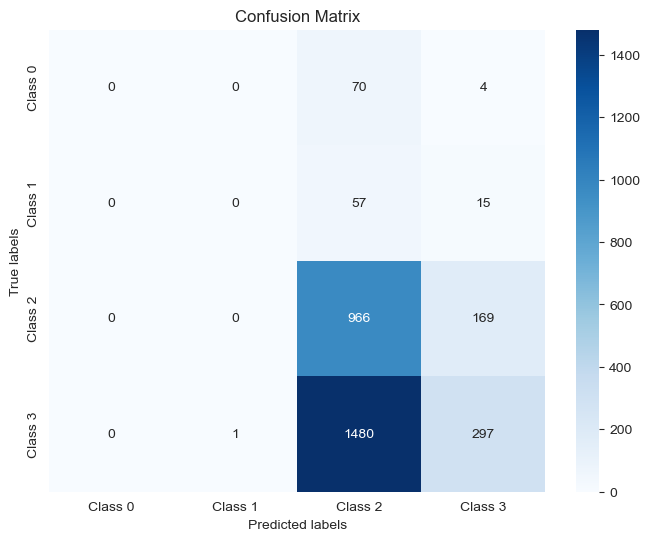

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)

class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [133]:
with torch.no_grad():
    all_outputs = []
    all_guids = []
    for inputs, batch_guids in test_loader:
        inputs = inputs.to(device)
        output = model(inputs)
        _, output = torch.max(output, 1)
        all_outputs.extend(output)
        all_guids.extend(batch_guids)


In [134]:
# Convert lists to DataFrame
all_outputs_cpu = [output.cpu().detach().numpy() for output in all_outputs]

# Convert lists to DataFrame
data = {'guid': all_guids, 'label': all_outputs_cpu}
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('./data/output.csv', index=False)

print("CSV file saved successfully.")

CSV file saved successfully.
